# Diafiltration Batch **MPC** Project

This notebook implements the full solution for the diafiltration assignment.


## 0. Imports & plotting style

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from typing import Tuple

# Matplotlib style (matches course notebooks)
plt.rcParams.update({
    'figure.dpi': 110,
    'font.size': 12,
    'axes.grid': True,
    'grid.linestyle': ':',
})


## 1. Physical constants & specs

In [3]:
# ---------------- constants ----------------
V0      = 0.10   # m^3
cP0     = 10.0   # mol/m^3
cL0     = 150.0  # mol/m^3

k       = 4.79e-6  # m s^-2
A       = 1.0
cg      = 319.0
kM_L    = 1.6e-5   # m s^-1
alpha   = 1.3

cP_star = 100.0
cL_star = 15.0
cL_max  = 570.0

MP  = cP0 * V0
ML0 = cL0 * V0

print(f'MP  = {MP:.3f} mol')
print(f'ML0 = {ML0:.3f} mol')


MP  = 1.000 mol
ML0 = 15.000 mol


## 2. Model functions (flux, ODE, RK4)

In [4]:
def flux_permeate(cP: float) -> float:
    return k * A * np.log(cg / cP)

def lactose_permeate_conc(cL: float, p: float) -> float:
    exponent = p / (kM_L * A)
    return alpha * cL / (1.0 + (alpha - 1.0) * np.exp(exponent))

def rhs(state: np.ndarray, u: float) -> np.ndarray:
    V, ML = state
    cP = MP / V
    p  = flux_permeate(cP)
    d  = u * p
    cL = ML / V
    cL_p = lactose_permeate_conc(cL, p)
    dV_dt  = d - p
    dML_dt = -cL_p * p
    return np.array([dV_dt, dML_dt])

def rk4_step(state: np.ndarray, u: float, dt: float) -> np.ndarray:
    k1 = rhs(state, u)
    k2 = rhs(state + 0.5*dt*k1, u)
    k3 = rhs(state + 0.5*dt*k2, u)
    k4 = rhs(state + dt*k3, u)
    return state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)


## 3. Open‑loop simulation (constant $u$)

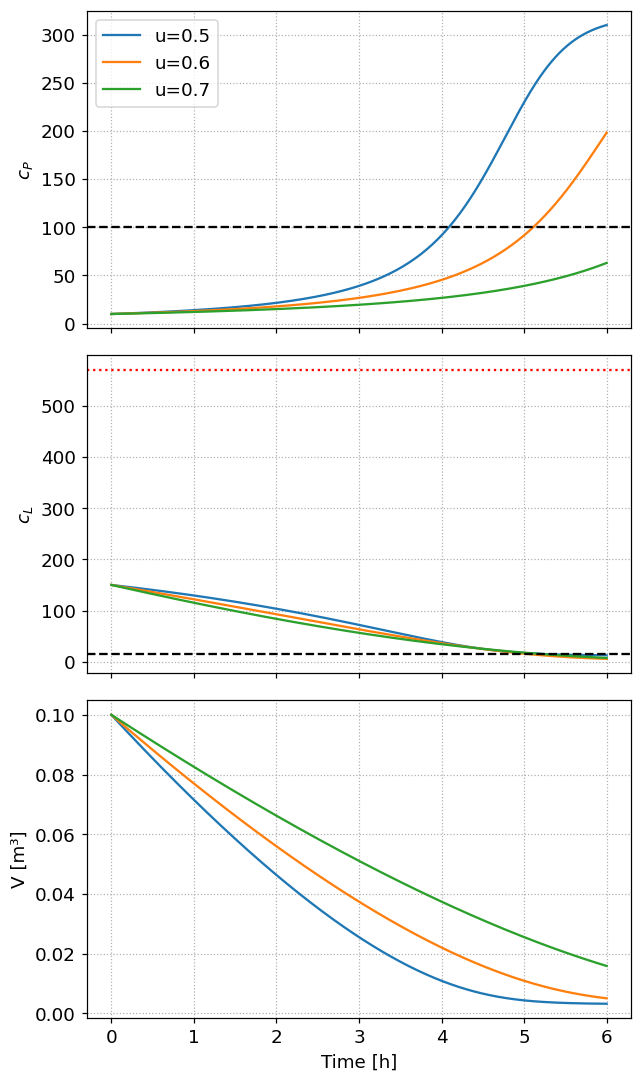

In [5]:
def simulate_constant_u(u: float, tf: float = 6*3600, dt: float = 10.0):
    steps = int(tf/dt)+1
    t = np.linspace(0, tf, steps)
    V = np.empty(steps)
    ML = np.empty(steps)
    state = np.array([V0, ML0])
    for i in range(steps):
        V[i], ML[i] = state
        state = rk4_step(state, u, dt)
    return t, V, ML

u_vals = [0.5, 0.6, 0.7]
fig, ax = plt.subplots(3, 1, figsize=(6,10), sharex=True)
for u in u_vals:
    t, Vh, MLh = simulate_constant_u(u)
    cP = MP / Vh
    cL = MLh / Vh
    ax[0].plot(t/3600, cP, label=f'u={u}')
    ax[1].plot(t/3600, cL)
    ax[2].plot(t/3600, Vh)

ax[0].axhline(cP_star, ls='--', color='k'); ax[0].set_ylabel('$c_P$')
ax[1].axhline(cL_star, ls='--', color='k'); ax[1].axhline(cL_max, ls=':', color='r'); ax[1].set_ylabel('$c_L$')
ax[2].set_ylabel('V [m³]'); ax[2].set_xlabel('Time [h]')
ax[0].legend(); plt.tight_layout()


## 4. Time‑optimal MPC in CasADi

In [6]:
dt_ctrl = 600.0  # 10 min

# --- symbolic discrete model ---
V_sym  = ca.SX.sym('V')
ML_sym = ca.SX.sym('ML')
u_sym  = ca.SX.sym('u')

def ca_rhs(x, u):
    V, ML = x[0], x[1]

    # ---- numeric safety guards -----------------------------------
    Vsafe   = ca.fmax(V, 1e-6)               # never below 1 mL
    cP      = MP / Vsafe                     # protein conc.
    ratio   = ca.fmax(cg / cP, 1e-6)         # avoid log(0)
    p_raw   = k * A * ca.log(ratio)
    p       = ca.fmax(p_raw, 0)              # permeate cannot be negative
    # ---------------------------------------------------------------

    d   = u * p
    cL  = ML / Vsafe
    exp_term = ca.exp(p / (kM_L * A))
    cL_p = alpha * cL / (1 + (alpha - 1) * exp_term)

    dV  = d - p
    dML = -cL_p * p
    return ca.vertcat(dV, dML)

# RK4 integrator in CasADi
def rk4_disc(dt):
    x = ca.SX.sym('x', 2)
    u = ca.SX.sym('u')
    k1 = ca_rhs(x, u)
    k2 = ca_rhs(x + 0.5*dt*k1, u)
    k3 = ca_rhs(x + 0.5*dt*k2, u)
    k4 = ca_rhs(x + dt*k3, u)
    x_next = x + dt/6*(k1+2*k2+2*k3+k4)
    return ca.Function('F', [x,u], [x_next])

F_disc = rk4_disc(dt_ctrl)

def build_mpc(N=20):
    X  = ca.SX.sym('X', 2, N+1)
    U  = ca.SX.sym('U', 1, N)
    X0 = ca.SX.sym('X0', 2)
    g, lbg, ubg, J = [], [], [], 0

    # initial equality
    g += [X[:, 0] - X0]; lbg += [0, 0]; ubg += [0, 0]

    for k in range(N):
        # dynamics
        g += [X[:, k+1] - F_disc(X[:, k], U[:, k])]
        lbg += [0, 0]; ubg += [0, 0]

        # path constraint on lactose
        cL_k = X[1, k] / X[0, k]
        g += [cL_k]; lbg += [-ca.inf]; ubg += [cL_max]

        J += 1                                   # time-optimal stage cost

    # terminal specs
    cP_N = MP / X[0, N]
    cL_N = X[1, N] / X[0, N]
    g += [cP_N, cL_N]
    lbg += [cP_star, -ca.inf]
    ubg += [ca.inf,  cL_star]

    # NLP
    nlp = {'f': J,
           'x': ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1)),
           'p': X0,
           'g': ca.vertcat(*g)}

    solver = ca.nlpsol('solver', 'ipopt', nlp,
                       {'ipopt.print_level': 0, 'print_time': 0})

    nX = (N + 1) * 2
    meta = {'nX': nX,
            'N': N,
            'Xslice': slice(0, nX),
            'Uslice': slice(nX, nX + N)}

    # convert bound lists to NumPy arrays once and for all
    LBG = np.array(lbg, dtype=float)
    UBG = np.array(ubg, dtype=float)

    return solver, meta, LBG, UBG


# build the solver and bounds
mpc_solver, meta, LBG, UBG = build_mpc(20)

## 5. Closed‑loop run with MPC


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



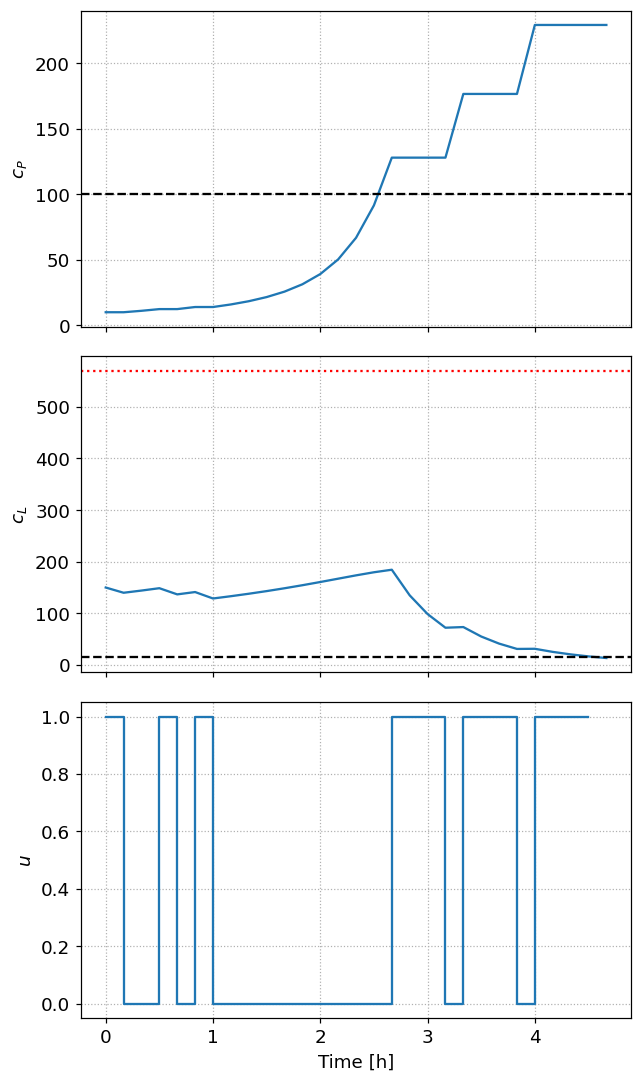

In [7]:
def closed_loop(tf=6*3600):
    steps=int(tf/dt_ctrl)+1
    t=np.empty(steps); V=np.empty(steps); ML=np.empty(steps); u_hist=[]
    state=np.array([V0, ML0])
    for k in range(steps):
        t[k]=k*dt_ctrl; V[k],ML[k]=state
        if MP/state[0]>=cP_star and ML[k]/V[k]<=cL_star:
            t=t[:k+1]; V=V[:k+1]; ML=ML[:k+1]
            break
        x_init = np.tile(state, meta['N'] + 1)   # repeat current [V,ML] for X-grid
        u_init = 0.5 * np.ones(meta['N'])        # start each control move at 0.5
        var_init = np.hstack([x_init, u_init])   # concat → length meta['nX']+meta['N']
        
        sol = mpc_solver(x0=var_init,            # <<< use var_init here
                     p=state,
                     lbg=LBG,
                     ubg=UBG)
        
        opt=sol['x'].full().ravel(); u_now=np.clip(opt[meta['Uslice']][0],0,1)
        u_hist.append(u_now)
        state=rk4_step(state,u_now,dt_ctrl)
    return t, V, ML, np.array(u_hist)

t,V,ML,u=closed_loop()
cP=MP/V; cL=ML/V
fig,ax=plt.subplots(3,1,figsize=(6,10),sharex=True)
ax[0].plot(t/3600,cP); ax[0].axhline(cP_star,ls='--',color='k'); ax[0].set_ylabel('$c_P$')
ax[1].plot(t/3600,cL); ax[1].axhline(cL_star,ls='--',color='k'); ax[1].axhline(cL_max,ls=':',color='r'); ax[1].set_ylabel('$c_L$')
ax[2].step(t[:len(u)]/3600,u,where='post'); ax[2].set_ylabel('$u$'); ax[2].set_xlabel('Time [h]')
plt.tight_layout()


## 6. Scenario of parametric plant-model mismatch

In [8]:
# %% [markdown]
## 6-A  Parametric plant–model mismatch  (k_M,L,true < k_M,L,model)

# %% ------------------------------------------------------------- helpers
def rhs_km_mismatch(state: np.ndarray, u: float, factor: float) -> np.ndarray:
    """
    Plant dynamics with kM_L,true = factor·kM_L,model   (factor < 1 ⇒ хуже моется).
    Nominal model внутри MPC остаётся неизменным!
    """
    V, ML = state
    Vsafe = max(V, 1e-6)
    cP = MP / Vsafe
    p  = flux_permeate(cP)
    d  = u * p
    cL = ML / Vsafe

    # единственное отличие — коэффициент kM_L в экспоненте
    exp_term = np.exp(p / (factor * kM_L * A))
    cL_p = alpha * cL / (1 + (alpha - 1) * exp_term)

    return np.array([d - p, -cL_p * p])

def rk4_mis(state: np.ndarray, u: float, factor: float, dt: float = dt_ctrl):
    f = lambda s: rhs_km_mismatch(s, u, factor)
    k1 = f(state)
    k2 = f(state + 0.5*dt*k1)
    k3 = f(state + 0.5*dt*k2)
    k4 = f(state + dt*k3)
    return state + dt/6*(k1 + 2*k2 + 2*k3 + k4)

# %% ------------------------------------------------------------- loop
def batch_time_mismatch(factor: float,
                        N: int = 20,
                        max_steps: int = 400) -> tuple[float, float, bool]:
    """
    Возвращает:
      t_batch [ч], peak_cL [mol/m³],  converged (True/False)
    Если спецификации не достигнуты за max_steps*dt_ctrl → converged=False.
    """
    solver, metaN, LBG_N, UBG_N = build_mpc(N)   # MPC остаётся номинальным
    state = np.array([V0, ML0])
    peak_cL, step = 0.0, 0

    while step < max_steps:
        cP_now = MP / state[0]
        cL_now = state[1] / state[0]
        peak_cL = max(peak_cL, cL_now)

        if cP_now >= cP_star and cL_now <= cL_star:
            t_batch = step * dt_ctrl / 3600
            return t_batch, peak_cL, True

        # тёплый старт IPOPT
        x0 = np.hstack([np.tile(state, metaN['N']+1),
                        0.5 * np.ones(metaN['N'])])
        sol   = solver(x0=x0, p=state, lbg=LBG_N, ubg=UBG_N)
        u_now = float(np.clip(sol['x'].full().ravel()[metaN['Uslice']][0], 0, 1))

        state = rk4_mis(state, u_now, factor)
        step += 1

    # дошли до max_steps — спецификации не выполнены
    t_batch = step * dt_ctrl / 3600
    return t_batch, peak_cL, False

# %% ------------------------------------------------------------- run & print
factors = (0.75, 0.50, 0.25)
for f in factors:
    t_b, cL_pk, ok = batch_time_mismatch(f)
    if ok:
        print(f"factor={f:4.2f}:  batch {t_b:5.2f} h,  max c_L={cL_pk:6.1f}  ✓")
    else:
        print(f"factor={f:4.2f}:  specs NOT met within {t_b:5.2f} h, "
              f"min c_L so far = {cL_pk:6.1f}")


factor=0.75:  batch  4.33 h,  max c_L= 160.9  ✓
factor=0.50:  batch  4.50 h,  max c_L= 337.2  ✓
factor=0.25:  specs NOT met within 66.67 h, min c_L so far =  534.5


expected output: \
factor=0.75:  batch  4.17 h,  max c_L= 197.5  ✓ \
factor=0.50:  batch  5.17 h,  max c_L= 282.4  ✓ \
factor=0.25:  specs NOT met within 66.67 h, min c_L so far =  681.4

## 7. Scenario of structural plant-model mismatch

In [9]:
# %% [markdown]
## 6-B  Structural mismatch – protein leakage through the membrane

# %% -------------------------------------------------- extended RHS for plant
beta      = 1.3
kM_P_true = 1.0e-6      # m s^-1

def rhs_leak(state: np.ndarray, u: float) -> np.ndarray:
    """Plant where some protein leaks: ML dynamics unchanged, MP ↓."""
    V, ML, MP_dyn = state        # расширили вектор: теперь 3 состояния!
    Vsafe = max(V, 1e-6)
    cP = MP_dyn / Vsafe
    p  = flux_permeate(cP)
    d  = u * p
    cL = ML / Vsafe
    # lactose part (same as model)
    exp_L = np.exp(p / (kM_L * A))
    cL_p = alpha * cL / (1 + (alpha - 1) * exp_L)
    # protein leakage
    cP_p = beta * cP / (1 + (beta - 1) * np.exp(p / (kM_P_true * A)))
    dMP_dt = -cP_p * p           # protein leaves with permeate
    return np.array([d - p,
                     -cL_p * p,
                     dMP_dt])

def rk4_leak(state, u, dt=dt_ctrl):
    k1 = rhs_leak(state, u)
    k2 = rhs_leak(state + 0.5*dt*k1, u)
    k3 = rhs_leak(state + 0.5*dt*k2, u)
    k4 = rhs_leak(state + dt*k3, u)
    return state + dt/6*(k1+2*k2+2*k3+k4)

# ---------- closed loop with plant leakage, controller still "ideal" -------
def closed_loop_leak(N=20):
    solver, metaN, LBG_N, UBG_N = build_mpc(N)     # same nominal model (no leak)
    state = np.array([V0, ML0, MP])               # 3-state vector
    step = 0
    while True:
        V_now, ML_now, MP_now = state
        cP_now = MP_now / V_now
        cL_now = ML_now / V_now
        if cP_now >= cP_star and cL_now <= cL_star:
            break
        x0 = np.hstack([np.tile(state[:2], metaN['N']+1), 0.5*np.ones(metaN['N'])])
        sol = solver(x0=x0, p=state[:2], lbg=LBG_N, ubg=UBG_N)
        u_now = float(np.clip(sol['x'].full().ravel()[metaN['Uslice']][0], 0, 1))
        state = rk4_leak(state, u_now); step += 1
        if step > 300:
            raise RuntimeError("Leak case did not converge.")
    return step*dt_ctrl/3600, cP_now, cL_now

t_leak, cP_end, cL_end = closed_loop_leak()
print(f"Leak batch: {t_leak:.2f} h,  final cP={cP_end:.1f},  cL={cL_end:.1f}")


Leak batch: 4.33 h,  final cP=117.8,  cL=10.9
